In [1]:
import numpy as np
import scipy.io
from utils import *
import matplotlib.pyplot as plt

In [2]:
folder = './real_data/lines/'
keyword = 'CD60eb'
roi_size_px = 332
recon_alg = 'GN'

In [3]:
# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m
# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m


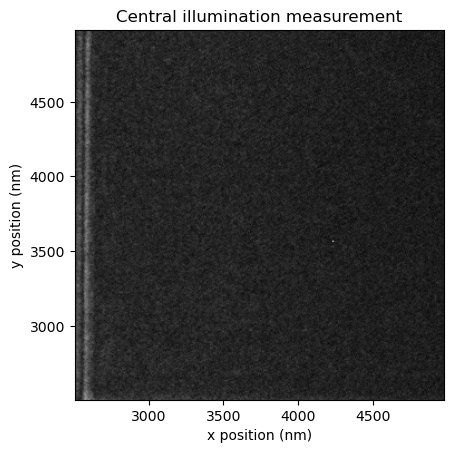

In [4]:
# todo: find central measurement as a comparison

path = folder + keyword + '.npz'
data = np.load(path)
img = data['imgs']
img = [img[i,:,:] for i in range(img.shape[0])]
sx = data['sx']
sy = data['sy']


# center crop if using ROI
if roi_size_px < img[0].shape[0]:
    ROI_center =  [img[0].shape[0]//2, img[0].shape[1]//2]
    x_m = x_m[ROI_center[0]-int(roi_size_px/2):ROI_center[0]+int(roi_size_px/2)]
    y_m = y_m[ROI_center[1]-int(roi_size_px/2):ROI_center[1]+int(roi_size_px/2)]
    img = [i[ROI_center[0]-int(roi_size_px/2):ROI_center[0]+int(roi_size_px/2), 
             ROI_center[1]-int(roi_size_px/2):ROI_center[1]+int(roi_size_px/2)] for i in img]


# find the central illumination measurement  with sx = 0 and sy = 0
center_idx = np.where(np.logical_and(sx == 0, sy == 0))[0][0]
center_img = img[center_idx]

# plot 

plt.figure(1)
plt.imshow(np.sqrt(center_img), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Central illumination measurement')
plt.show()

    

check the measurement stack to reject those with overlapping bright shadows

In [5]:
# view the meas stack with a slider
from ipywidgets import interact

def view_meas_stack(i):
    plt.figure()
    plt.imshow(img[i], cmap='gray')
    plt.show()

interact(view_meas_stack, i=(0, len(img)-1, 1))

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

<function __main__.view_meas_stack(i)>

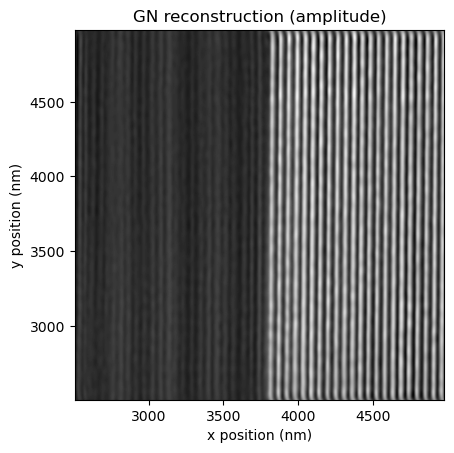

<Figure size 640x480 with 0 Axes>

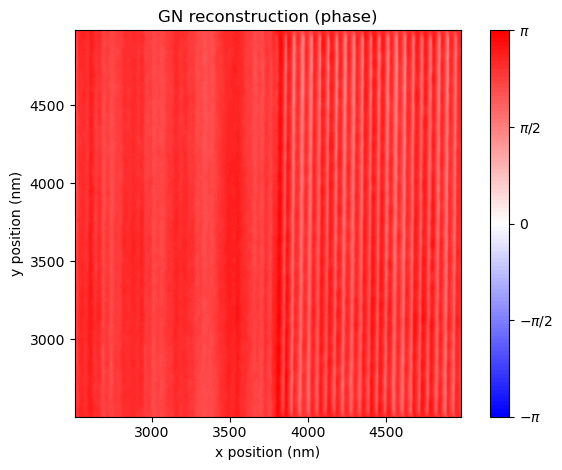

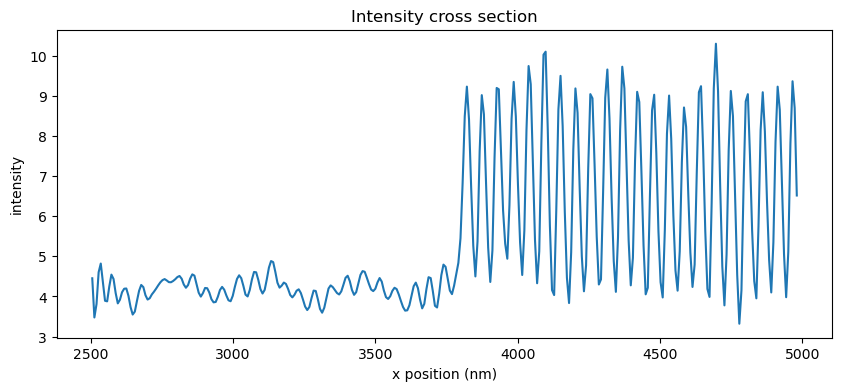

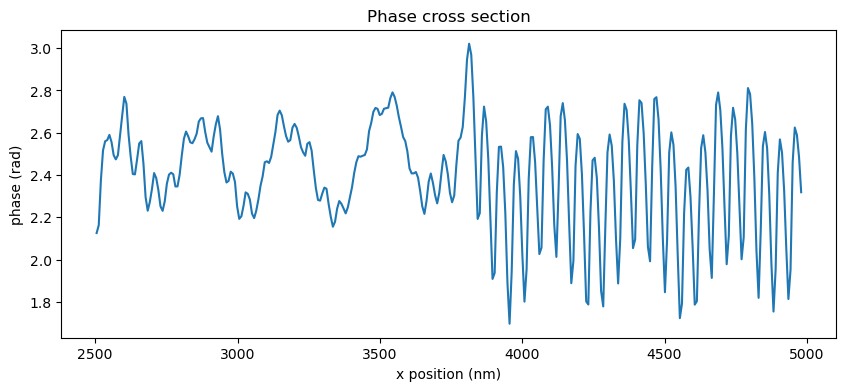

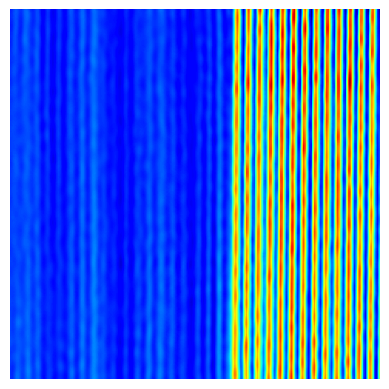

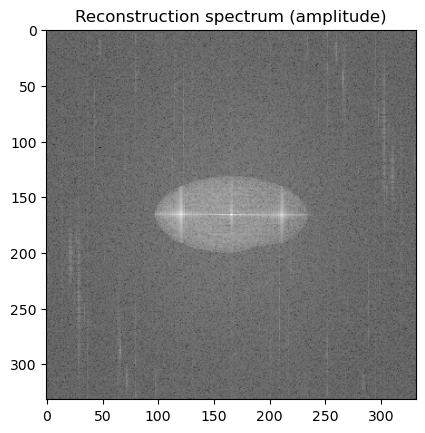

In [6]:
def load_recon(folder, recon_alg, downsample=False):
    if recon_alg == 'APIC':
        filename = f'{folder}result/{keyword}_APIC_{str(roi_size_px)}.mat'
        recon = scipy.io.loadmat(filename)
        object_guess = recon['himMatching']
        pupil_recon = recon['CTF_abe']
        pupil_recon = np.fliplr(pupil_recon)
        pupil_recon = np.flipud(pupil_recon)
    else:
        recon = scipy.io.loadmat(f'{folder}/result/{keyword}_{recon_alg}_recon.mat')
        object_guess = recon['obj']
        if 'pupil' in recon:
            pupil_recon = recon['pupil']
            full_recon_flag = False
        else:
            pupil_recon = recon['pupil_array']
            full_recon_flag = True
        ideal_FILTER = recon['ideal_FILTER']

    if downsample:        
        if recon_alg == 'GN' or recon_alg == 'APIC':
            downsampled_size = roi_size_px
            size_px = object_guess.shape[0]
            object_guess = ft(object_guess)
            object_guess = object_guess[size_px//2-downsampled_size//2:size_px//2+downsampled_size//2, size_px//2-downsampled_size//2:size_px//2+downsampled_size//2]
            object_guess = ift(object_guess)
    
    return object_guess, pupil_recon, ideal_FILTER, full_recon_flag



object_guess, pupil_recon, ideal_FILTER, full_recon_flag = load_recon(folder, recon_alg, downsample=True)


def object_guess_plots(object_guess):
    plt.figure(1)
    plt.imshow(np.abs(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
    plt.xlabel('x position (nm)')
    plt.ylabel('y position (nm)')
    plt.title(f'{recon_alg} reconstruction (amplitude)')
    plt.show()

    plt.figure(2)
    # Define custom colormap: Blue -> White -> Red
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_diverging', colors, N=100)

    fig, ax = plt.subplots()
    # Plot the phase of object_guess
    cax = ax.imshow(
        np.angle(object_guess),
        extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9],
        cmap=cmap, vmin=-np.pi, vmax=np.pi
    )
    ax.set_xlabel('x position (nm)')
    ax.set_ylabel('y position (nm)')
    ax.set_title(f'{recon_alg} reconstruction (phase)')
    cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
    plt.tight_layout()
    plt.show()

    # show a cross section of the intensity and phase
    x_vals = np.linspace(x_m[0]*1e9, x_m[-1]*1e9, object_guess.shape[1])
    plt.figure(3, figsize=(10, 4))
    plt.plot(x_vals, np.abs(object_guess)[roi_size_px//2, :])
    plt.xlabel('x position (nm)')
    plt.ylabel('intensity')
    plt.title('Intensity cross section')
    plt.show()

    plt.figure(4, figsize=(10, 4))
    plt.plot(x_vals, np.angle(object_guess)[roi_size_px//2, :])
    plt.xlabel('x position (nm)')
    plt.ylabel('phase (rad)')
    plt.title('Phase cross section')
    plt.show()


    # center
    plt.figure(5)
    patch = np.abs(object_guess)[10:250, 30:270]
    # bottom right corner
    # patch = np.abs(object_guess)[10:250, 20:260]
    plt.imshow(patch, cmap='jet')
    plt.axis('off')
    plt.show()


    # show the intensity of the recon spectrum
    plt.figure(6)
    plt.imshow(np.log(np.abs(ft(object_guess)+1)), cmap='gray')
    plt.title('Reconstruction spectrum (amplitude)')
    plt.show()


object_guess_plots(object_guess)


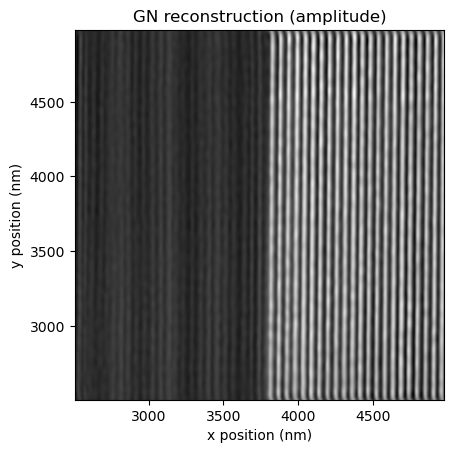

<Figure size 640x480 with 0 Axes>

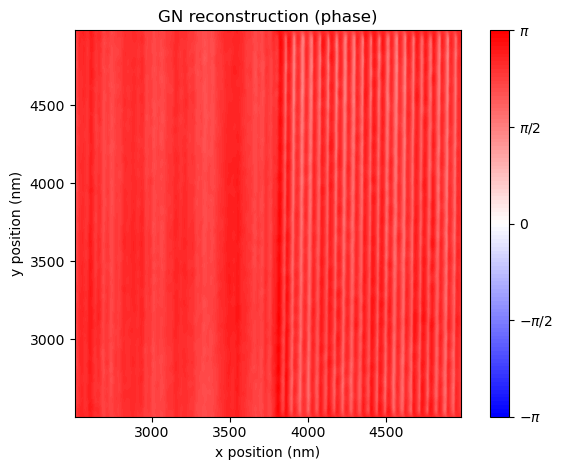

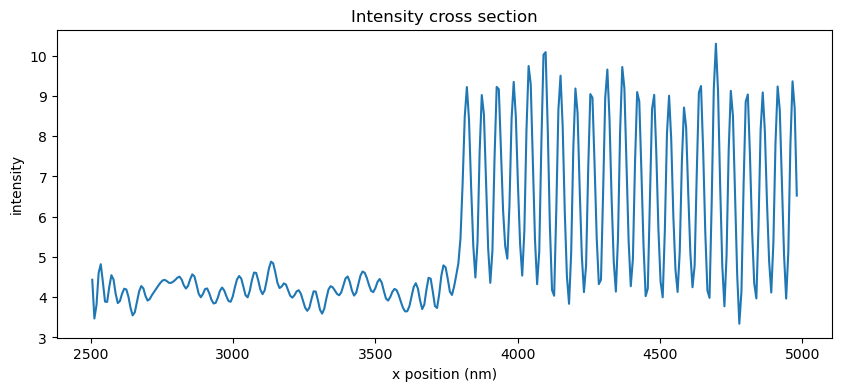

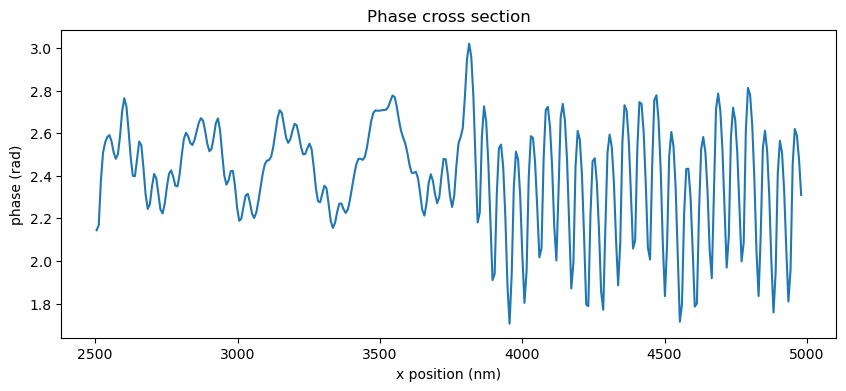

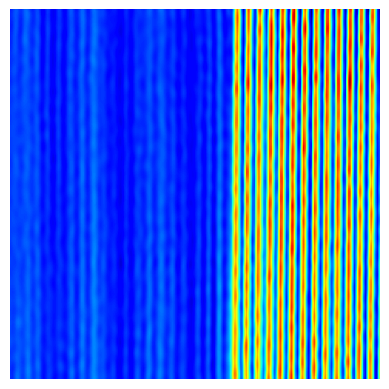

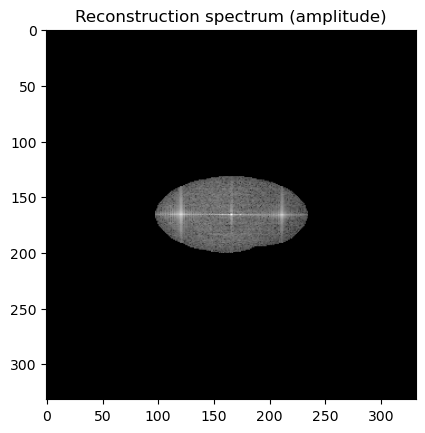

In [7]:
# filter the recon with ideal filter
recon_filtered = ift(ft(object_guess) * ideal_FILTER)

object_guess_plots(recon_filtered)

In [8]:
def FP_forward(spectrum_guess, lens_guess, X, Y, meas):
    pred = np.zeros_like(meas)
    for idx in range(len(X)):
        shifted_spectrum = circshift2(spectrum_guess, -X[idx], -Y[idx])
        pred[idx] = np.abs(ift(shifted_spectrum * lens_guess))
    return pred

meas = np.array(img)
pred = FP_forward(ft(object_guess), pupil_recon, sx, sy, meas)
amplitude_loss = np.mean((pred - np.sqrt(meas))**2)
print(amplitude_loss)


866.7132


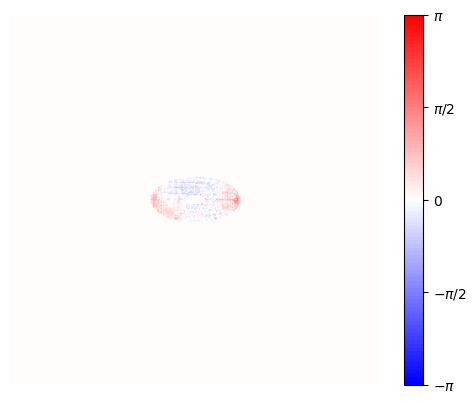

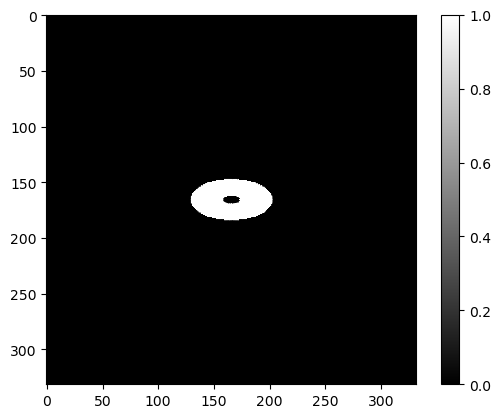

In [9]:
def show_phase(phase):
    # color map
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> W -> B
    cmap_name = 'custom_diverging'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    # crop center region
    range = 150
    size = phase.shape[0]
    img = phase[size//2-range:size//2+range, size//2-range:size//2+range]

    fig, ax = plt.subplots()
    cax = ax.imshow(img, cmap=cm, vmin=-np.pi, vmax=np.pi)  # Adjust the limits to -pi to pi for your use case
    plt.axis('off')
    
    # Create colorbar
    cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$']) 
    
    plt.show()
    
show_phase(np.angle(pupil_recon))


plt.figure(5)
plt.imshow(np.abs(pupil_recon), cmap='gray')
plt.clim(0, 1)
plt.colorbar()  
